In [1]:
# %pip install -U lightgbm==3.3.2

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
# !ln -s /home/tarique/myvenv/lib/gcc/x86_64-linux-gnu/5.4.0/libgomp.so /usr/lib/x86_64-linux-gnu/
# /home/tarique/myvenv/lib/gcc/x86_64-linux-gnu/5.4.0/libgomp.so

In [4]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
from src.retrieval.collector import RuleCollector

from src.features import cum_sale, week_sale, repurchase_ratio, purchased_before, popularity

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity
)

In [5]:
data_dir = Path("../src/data/")
model_dir = Path("../src/models/")

In [6]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2
VERSION_NAME = "pivot"# "v1"
# VERSION_NAME = "Large_Recall"# "v1"

valid_week = 1
train_n_week = TRAIN_WEEK_NUM

In [7]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

In [8]:
TEST = True # * Set as `False` when do local experiments to save time

Pepare data: encoding ids and preprocessing

In [9]:
dh = DataHelper(data_dir)

In [10]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [11]:
data = dh.load_data(name="encoded_full")

In [12]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [13]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'], 5, labels=False)
del user_info['mean_price']

listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [14]:
# # * WEEK_NUM = 0: test
# # * WEEK_NUM = 1: valid
# # * WEEK_NUM > 1: train

# for week in range(1, WEEK_NUM):
#     # * use sliding window to generate candidates
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")
    
#     last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
#     last_week_start = last_week_start.strftime("%Y-%m-%d")
    
#     last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
#     last_3day_start = last_3day_start.strftime("%Y-%m-%d")

#     train, valid = dh.split_data(trans, start_date, end_date)

#     last_week = train.loc[train.t_dat >= last_week_start]
#     last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     last_3days = train.loc[train.t_dat >= last_3day_start]
#     last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         week_num = week,
#         trans_df = trans,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, 3),
#             OrderHistory(train, 7),
#             OrderHistoryDecay(train, 3, n=50),
#             OrderHistoryDecay(train, 7, n=50),
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
#             UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50),
#             TimeHistory(customer_list, last_week, n=50, name='1'),
#             TimeHistory(customer_list, last_3days, n=50, name='2'),
#             TimeHistoryDecay(customer_list, train, 3, n=50),
#             TimeHistoryDecay(customer_list, train, 7, n=50),
#             SaleTrend(customer_list, train, 7, n=50),
#         ],
#         filters=[OutOfStock(trans)],
#         min_pos_rate=0.005,
#         compress=False,
#     )
    
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#     )

#     rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
#     candidates['score'] = candidates[rule_names].sum(axis=1)
#     candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    
#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     if WEEK_NUM != 0:
#         valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

In [15]:
# # * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 

# for week in range(1):
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")
    
#     last_5week_start = pd.to_datetime(start_date) - 5*pd.Timedelta(days=7)
#     last_5week_start = last_5week_start.strftime("%Y-%m-%d")
    
#     last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
#     last_week_start = last_week_start.strftime("%Y-%m-%d")
    
#     last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
#     last_3day_start = last_3day_start.strftime("%Y-%m-%d")

#     train, valid = dh.split_data(trans, start_date, end_date)
    
#     last_5week = train.loc[train.t_dat >= last_5week_start]
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     last_week = train.loc[train.t_dat >= last_week_start]
#     last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     last_3days = train.loc[train.t_dat >= last_3day_start]
#     last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         week_num = week,
#         trans_df = trans,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, 3),
#             OrderHistory(train, 7),
#             OrderHistoryDecay(train, 3, n=50),
#             OrderHistoryDecay(train, 7, n=50),
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=35, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=38.5, name='2'),
#             UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=3),
#             TimeHistory(customer_list, last_week, n=25, name='1'),
#             TimeHistory(customer_list, last_3days, n=30, name='2'),
#             TimeHistoryDecay(customer_list, train, 3, n=31),
#             TimeHistoryDecay(customer_list, train, 7, n=24),
#             SaleTrend(customer_list, train, 7, n=4),
#         ],
#         filters=[OutOfStock(trans)],
#         min_pos_rate=0.005,
#         compress=False,
#     )
    
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#     )

#     rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
#     candidates['score'] = candidates[rule_names].sum(axis=1)
#     candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)

#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     if WEEK_NUM != 0:
#         valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

In [16]:
# del train, valid, last_week, customer_list, candidates
# gc.collect()

## Feature engineering


In [17]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [18]:
# # merge `product_code`
# data['user']['age_bucket'] = pd.cut(data['user']['age'].fillna(22), [-1, 19, 29, 39, 49, 59, 69, 119],
#                                     labels=[0, 1, 2, 3, 4, 5, 6])
# inter = inter.merge(item[["article_id", "product_code", "department_no"]], on="article_id", how="left")
# inter = inter.merge(user[["customer_id", "age_bucket"]], on="customer_id", how="left")
# inter["age_bucket"] = inter["age_bucket"].astype(int)
# # calculate week number
# inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
# inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [19]:
# inter.head()

In [20]:
# inter.shape

Week Sale

In [21]:
# inter["i_sale"] = week_sale(inter, ["article_id"])
# inter["p_sale"] = week_sale(inter, ["product_code"])
# inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
# inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
# inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
# inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
# inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
# inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

# inter["i_sale_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"])
# inter["p_sale_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"])
# inter["i_sale_uni_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"], True)
# inter["p_sale_uni_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"], True)

# inter["i_sale_by_age"] = week_sale(inter, ["article_id","age_bins"])
# inter["p_sale_by_age"] = week_sale(inter, ["product_code","age_bins"])
# inter["i_sale_by_dept"] = week_sale(inter, ["article_id","department_no"])
# inter["p_sale_by_dept"] = week_sale(inter, ["product_code","department_no"])
# inter["i_sale_by_dept_channel"] = week_sale(inter, ["article_id","department_no","sales_channel_id"])
# inter["p_sale_by_dept_channel"] = week_sale(inter, ["product_code","department_no","sales_channel_id"])

# inter["i_sale_uni_by_age"] = week_sale(inter, ["article_id","age_bucket"], True)
# inter["p_sale_uni_by_age"] = week_sale(inter, ["product_code","age_bucket"], True)
# inter["lw_i_sale_by_age"] = week_sale(inter, ["article_id","age_bucket"], step=1)
# inter["lw_p_sale_by_age"] = week_sale(inter, ["product_code","age_bucket"], step=1)

# inter["i_sale_by_channel_age"] = week_sale(inter, ["article_id","sales_channel_id","age_bucket"])
# inter["p_sale_by_channel_age"] = week_sale(inter, ["product_code","sales_channel_id","age_bucket"])
# inter["i_sale_uni_by_channel_age"] = week_sale(inter, ["article_id","sales_channel_id","age_bucket"], True)
# inter["p_sale_uni_by_channel_age"] = week_sale(inter, ["product_code","sales_channel_id","age_bucket"], True)
# inter["i_sale_by_dept_age"] = week_sale(inter, ["article_id","department_no","age_bucket"])
# inter["p_sale_by_dept_age"] = week_sale(inter, ["product_code","department_no","age_bucket"])

In [22]:
# inter["lw_i_sale_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"], step=1)
# inter["lw_p_sale_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"], step=1)

# inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
# inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
# inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
# inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

# inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
# inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
# inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
# inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

# inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
# inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

# item_feats = [
#     "product_type_no",
#     "product_group_name",
#     "graphical_appearance_no",
#     "colour_group_code",
#     "perceived_colour_value_id",
#     "perceived_colour_master_id",
# ]
# inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

# for f in tqdm(item_feats):
#     inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
#     inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
#     inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)
    
# inter = inter.drop(columns=item_feats)

In [23]:
##Repurchase Ratio
# inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
# inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

##Popularity
# inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
# inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

##Already Bought Item
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

In [24]:
## inter.to_parquet(data_dir / "interim/processed_inter.pqt")
### inter.to_parquet(data_dir / "interim/processed_inter_v2.pqt")
# inter.to_parquet(data_dir / "interim/processed_inter_v3.pqt")

## Merge Features


In [25]:
# inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
# inter = pd.read_parquet(data_dir / "interim/processed_inter_v2.pqt")
# inter = pd.read_parquet(data_dir / "interim/processed_inter_v3.pqt")

In [26]:
# data["inter"] = inter

In [27]:
# data["inter"]['label'] = 1
# data["inter"][['customer_id', 'article_id', 'label']]

Merge user and item embeddings

In [28]:
# #* embeddings from DSSM model
# dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
# dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)\
# # * embeddings from YouTubeDNN model
# yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
# yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

# for i in tqdm(range(WEEK_NUM)):
#     if i == 0 and not TEST:
#         continue
        
#     candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
#     # * merge features
#     candidate = merge_week_data(data, i, candidate)
#     candidate = candidate.merge(article_cluster[['article_id','colour_group_name_cat_cat_code', 'cluster',
#                                                          'department_no_cluster']],  on='article_id', how='left')
    
#     candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
#     candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
#     candidate.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    
# del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd, article_cluster, itemid2idx

In [29]:
# def merge_new_groups(trans, week_num, candidates):
    
#     trans = trans.sort_values(by=["t_dat", "customer_id"]).reset_index(drop=True)

#     trans_info = (
#         trans[trans["week"] == week_num + 1]
#         .sort_values(by=["t_dat", "customer_id"])
#         .reset_index(drop=True)
#         .groupby(["week", "article_id"], as_index=False)
#         .last()
#         .drop(columns=["customer_id"])
#     )

#     trans_info["week"] = week_num
#     trans_info, _ = reduce_mem_usage(trans_info)

#     candidates = candidates.merge(trans_info.drop(['t_dat', 'week'], axis=1), on="article_id", how="left")
    
#     candidates, _ = reduce_mem_usage(candidates)

#     return candidates

In [30]:
# candidates = {}
# for i in tqdm(range(1, WEEK_NUM)):
#     candidates[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

In [31]:
# for i in tqdm(range(1, WEEK_NUM)):
#     if i in candidates:
#         candidates[i] = merge_new_groups(data["inter"], i, candidates[i])
#         candidates[i].to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

## Ranking


In [32]:
article_cluster = pd.read_parquet(data_dir/'articles_new.parquet')
# https://www.kaggle.com/code/beezus666/k-means-and-feature-importance-for-articles/notebook?scriptVersionId=94269787

itemid2idx = pickle.load(open(data_dir/"index_id_map/item_id2index.pkl", "rb"))
article_cluster['article_id'] = article_cluster['article_id'].map(itemid2idx)
article_cluster = article_cluster.rename(columns={'department_no':'department_no_cluster', 'ct':'cluster'})

In [33]:
candidates = {}
labels = {}
for i in tqdm(range(WEEK_NUM)):
    
#     candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
#     labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")
    
    candidates[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    labels[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 6/6 [01:51<00:00, 18.63s/it]


In [34]:
feats = [
    x
    for x in np.intersect1d(candidates[1].columns, candidates[2].columns)
    if x
    not in [
        "label",
        "t_dat",
        "week",
        'rank',
        'score'
    ]
]

In [35]:
feats

['ItemPairRetrieve_1',
 'ItemPairRetrieve_2',
 'ItemPairRetrieve_3',
 'ItemPairRetrieve_4',
 'OrderHistoryDecay_1',
 'OrderHistory_1',
 'TimeHistoryDecay_1',
 'TimeHistory_1',
 'TimeHistory_2',
 'UGTimeHistory_1',
 'UGTimeHistory_2',
 'age_bucket',
 'article_id',
 'cluster',
 'colour_group_code_sale',
 'colour_group_code_sale_trend',
 'colour_group_name_cat_cat_code',
 'customer_id',
 'department_no',
 'department_no_cluster',
 'dssm_similarity',
 'graphical_appearance_no_sale',
 'graphical_appearance_no_sale_trend',
 'i_pop',
 'i_repurchase_ratio',
 'i_sale',
 'i_sale_by_age',
 'i_sale_by_channel',
 'i_sale_by_channel_age',
 'i_sale_by_dept',
 'i_sale_by_dept_age',
 'i_sale_by_dept_channel',
 'i_sale_ratio',
 'i_sale_trend',
 'i_sale_uni',
 'i_sale_uni_by_age',
 'i_sale_uni_by_channel',
 'i_sale_uni_by_channel_age',
 'i_sale_uni_ratio',
 'i_uni_ratio',
 'lw_colour_group_code_sale',
 'lw_graphical_appearance_no_sale',
 'lw_i_sale',
 'lw_i_sale_by_age',
 'lw_i_sale_by_channel',
 'lw_i_s

In [36]:
cat_features = [
#     "FN",
#     "Active",
#     "club_member_status",
#     "fashion_news_frequency",
#     "product_type_no",
#     "product_group_name",
#     "graphical_appearance_no",
#     "colour_group_code",
#     "perceived_colour_value_id",
#     "perceived_colour_master_id",
#     "age",
#     "article_gender",
#     "season_type",
#     "user_gender",
    "customer_id",
    "article_id",
    "product_code",
    "sales_channel_id",
    "colour_group_name_cat_cat_code",
    "department_no",
    "age_bucket",
    "cluster",
    "department_no_cluster"
]

In [37]:
# # * Convert categorical featues as `CategoricalDtype`
# cate_dict = {}        
# for feat in tqdm(cat_features):
    
#     if feat !='age_bucket':
#         if feat in data['user'].columns:
#             value_set = set(data['user'][feat].unique())
#         elif feat in data['item'].columns:
#             value_set = set(data['item'][feat].unique())
#         elif feat in article_cluster.columns:
#             value_set = set(article_cluster[feat].unique())
#         else:
#             value_set = set(data['inter'][feat].unique())
#         cate_dict[feat] = CategoricalDtype(categories=value_set)
    
# for i in tqdm(range(WEEK_NUM)):
#     for feat in cat_features:
#         if feat !='age_bucket':
#             candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

In [38]:
# for i in tqdm(range(1, WEEK_NUM)):

#     candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

#     start_date, end_date = calc_valid_date(i)
#     mask = (start_date <= data["inter"]["t_dat"]) & (data["inter"]["t_dat"] < end_date)
#     label = data["inter"].loc[mask, ["customer_id", "article_id"]]
#     label = label.drop_duplicates(["customer_id", "article_id"])
#     label["label"] = 1
    
#     candidate = candidate.drop('label', axis=1)
#     candidate = candidate.merge(label[['customer_id', 'article_id', 'label']], 
#                                        on=['customer_id', 'article_id'], how='left')
#     candidate['label'] = candidate['label'].fillna(0)
#     candidate.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

In [39]:
# for i in tqdm(range(1, WEEK_NUM)):
    
#     candidates[i] = candidates[i].merge(data["inter"][['customer_id', 'article_id', 'label']], 
#                                        on=['customer_id', 'article_id'], how='left')
#     candidates[i]['label'] = candidates[i]['label'].fillna(0)
#     candidates[i].to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

## Train


In [70]:
def train_model(valid_week_num, train_week_num=4):
    
    params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 9,
    "num_leaves": 256,
    "learning_rate": 0.05,
    "verbose": -1,
    "eval_at": 12,
    }
    
    print("Validating week:", valid_week_num)
    
    full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))
    
    start_date, end_date = calc_valid_date(i)
    
    train = full_data[(valid_week_num < full_data["week"]) & (full_data["week"] <= valid_week_num + train_week_num)]
    valid = full_data[full_data["week"] == valid_week_num]
    train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
    valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
    
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week
    print("Train shape:", train.shape)

    train_group = train[["customer_id", "article_id", "week"]]
    train_group = train_group.astype("int")  # * convert to int to avoid `0` in groupby count result
    
    train_group = train_group.groupby(["week", "customer_id"])["article_id"].count().values

    valid_group = valid[["customer_id", "article_id"]]
    valid_group = valid_group.astype("int")  # * convert to int to avoid `0` in groupby count result
    
    valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    print("Training starts...!")

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
        
    return ranker

In [42]:
from sklearn.model_selection import KFold, StratifiedKFold

def train_binary_model(valid_week_num, train_week_num=1):
    
    print("Validating week:", valid_week_num)
    
    f_data = pd.concat(candidates[valid_week_num+j] for j in range(1, train_week_num+1))
    
    features = [col for col in f_data.columns if col in feats]
    
    X_train = f_data[features + ['label']].reset_index(drop=True)
    y_train = X_train['label']

    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)      
    for n_fold,(train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
        
        train = X_train.iloc[train_index].reset_index(drop=True)
        valid = X_train.iloc[test_index].reset_index(drop=True)

        print("Train positive rate:", train.label.mean())
        print("Train shape:", train.shape)
        print("Validation positive rate:", valid.label.mean())
        print("Validation shape:", valid.shape)

        params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": ["binary_logloss", "auc"],
        "max_depth": 9,
        "num_leaves": 256,
        "learning_rate": 0.05,
        "verbose": -1,
        "first_metric_only": True
        }

        train_set = lgb.Dataset(
            data=train[features],
            label=train["label"],
            feature_name=feats,
            categorical_feature=cat_features,
            params=params,
        )

        valid_set = lgb.Dataset(
            data=valid[features],
            label=valid["label"],
            feature_name=feats,
            categorical_feature=cat_features,
            params=params,
        )

        print("Training starts...!")

        ranker = lgb.train(
            params,
            train_set,
            num_boost_round=300,
            valid_sets=[valid_set],
            early_stopping_rounds=30,
            verbose_eval=10,
        )

        ranker.save_model(
            model_dir / f"lgb_binary_{n_fold}_{valid_week_num}.model",
            num_iteration=ranker.best_iteration,
        )

    return ranker, features

In [71]:
ranker = train_model(valid_week, train_n_week)
# 0.82846 4-week
# [35]	valid_0's map@12: 0.705772 3 week

Validating week: 1


KeyError: 'week'

In [40]:
# sns.set(rc={'figure.figsize':(8, 18)})
# feat_importance = pd.DataFrame(
#     {"feature": feats, "importance": ranker_2.feature_importance()}
# ).sort_values(by="importance", ascending=False)
# sns.barplot(y="feature", x="importance", data=feat_importance)

In [ ]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_5_1.model")

In [ ]:
ranker, trn_feats = train_binary_model(valid_week, train_n_week)

# [204]	valid_0's auc: 0.688491  3 week

Validating week: 1


0it [00:00, ?it/s]

Train positive rate: 0.002349522671969323
Train shape: (50353632, 88)
Validation positive rate: 0.002349542344866615
Validation shape: (12588409, 88)
Training starts...!
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.0146585	valid_0's auc: 0.859987
[20]	valid_0's binary_logloss: 0.01416	valid_0's auc: 0.864258
[30]	valid_0's binary_logloss: 0.0138977	valid_0's auc: 0.867357
[40]	valid_0's binary_logloss: 0.0137381	valid_0's auc: 0.869978
[50]	valid_0's binary_logloss: 0.0136227	valid_0's auc: 0.871921
[60]	valid_0's binary_logloss: 0.0135558	valid_0's auc: 0.873596
[70]	valid_0's binary_logloss: 0.0135099	valid_0's auc: 0.875069
[80]	valid_0's binary_logloss: 0.0134974	valid_0's auc: 0.876392
[90]	valid_0's binary_logloss: 0.0134485	valid_0's auc: 0.877354
[100]	valid_0's binary_logloss: 0.0137661	valid_0's auc: 0.878156
[110]	valid_0's binary_logloss: 0.0136511	valid_0's auc: 0.878679
[120]	valid_0's binary_logloss: 0.013701	valid_0's auc

1it [35:48, 2148.08s/it]

Train positive rate: 0.002349542484849107
Train shape: (50353633, 88)
Validation positive rate: 0.002349463093347467
Validation shape: (12588408, 88)
Training starts...!
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.0146403	valid_0's auc: 0.859463
[20]	valid_0's binary_logloss: 0.0141117	valid_0's auc: 0.86462
[30]	valid_0's binary_logloss: 0.0138376	valid_0's auc: 0.868205
[40]	valid_0's binary_logloss: 0.0136853	valid_0's auc: 0.870802
[50]	valid_0's binary_logloss: 0.0135735	valid_0's auc: 0.872945
[60]	valid_0's binary_logloss: 0.0135159	valid_0's auc: 0.874519
[70]	valid_0's binary_logloss: 0.0134547	valid_0's auc: 0.875942
[80]	valid_0's binary_logloss: 0.0133991	valid_0's auc: 0.877367
[90]	valid_0's binary_logloss: 0.0133592	valid_0's auc: 0.878613
[100]	valid_0's binary_logloss: 0.0133532	valid_0's auc: 0.879984
[110]	valid_0's binary_logloss: 0.0133186	valid_0's auc: 0.880915
[120]	valid_0's binary_logloss: 0.0135011	valid_0's a

2it [52:01, 1457.13s/it]

Train positive rate: 0.002349522625308883
Train shape: (50353633, 88)
Validation positive rate: 0.0023495425315099416
Validation shape: (12588408, 88)
Training starts...!
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.0146472	valid_0's auc: 0.858203
[20]	valid_0's binary_logloss: 0.0141456	valid_0's auc: 0.86393
[30]	valid_0's binary_logloss: 0.0138789	valid_0's auc: 0.867469
[40]	valid_0's binary_logloss: 0.0137119	valid_0's auc: 0.870531
[50]	valid_0's binary_logloss: 0.0136263	valid_0's auc: 0.872695
[60]	valid_0's binary_logloss: 0.0135342	valid_0's auc: 0.874342
[70]	valid_0's binary_logloss: 0.0134615	valid_0's auc: 0.875956
[80]	valid_0's binary_logloss: 0.0134663	valid_0's auc: 0.877329
[90]	valid_0's binary_logloss: 0.013571	valid_0's auc: 0.878541
[100]	valid_0's binary_logloss: 0.0135142	valid_0's auc: 0.879396
[110]	valid_0's binary_logloss: 0.0136398	valid_0's auc: 0.880261
[120]	valid_0's binary_logloss: 0.0137586	valid_0's a

3it [1:08:04, 1231.32s/it]

In [43]:
ranker, trn_feats = train_binary_model(valid_week, train_n_week)

Validating week: 1


3it [00:13,  3.15s/it]

Train positive rate: 0.002349522625308883
Train shape: (50353633, 88)
Validation positive rate: 0.0023495425315099416
Validation shape: (12588408, 88)
Training starts...!
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.0146849	valid_0's auc: 0.857526
[20]	valid_0's binary_logloss: 0.0141886	valid_0's auc: 0.862398
[30]	valid_0's binary_logloss: 0.0139126	valid_0's auc: 0.866612
[40]	valid_0's binary_logloss: 0.0137495	valid_0's auc: 0.869351
[50]	valid_0's binary_logloss: 0.0136471	valid_0's auc: 0.871597
[60]	valid_0's binary_logloss: 0.0135727	valid_0's auc: 0.873278
[70]	valid_0's binary_logloss: 0.0135268	valid_0's auc: 0.874808
[80]	valid_0's binary_logloss: 0.0134874	valid_0's auc: 0.876321
[90]	valid_0's binary_logloss: 0.0134734	valid_0's auc: 0.877116
[100]	valid_0's binary_logloss: 0.0134651	valid_0's auc: 0.878676
[110]	valid_0's binary_logloss: 0.0135979	valid_0's auc: 0.879456
[120]	valid_0's binary_logloss: 0.0135088	valid_0's

4it [36:07, 852.44s/it]

Train positive rate: 0.002349522625308883
Train shape: (50353633, 88)
Validation positive rate: 0.0023495425315099416
Validation shape: (12588408, 88)
Training starts...!
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.01466	valid_0's auc: 0.857602
[20]	valid_0's binary_logloss: 0.0141644	valid_0's auc: 0.862783
[30]	valid_0's binary_logloss: 0.0138909	valid_0's auc: 0.866712
[40]	valid_0's binary_logloss: 0.0137379	valid_0's auc: 0.869384
[50]	valid_0's binary_logloss: 0.0136285	valid_0's auc: 0.871474
[60]	valid_0's binary_logloss: 0.0135564	valid_0's auc: 0.873041
[70]	valid_0's binary_logloss: 0.013509	valid_0's auc: 0.874618
[80]	valid_0's binary_logloss: 0.0134667	valid_0's auc: 0.875935
[90]	valid_0's binary_logloss: 0.0135267	valid_0's auc: 0.876995
[100]	valid_0's binary_logloss: 0.0135342	valid_0's auc: 0.877913
[110]	valid_0's binary_logloss: 0.0139758	valid_0's auc: 0.878927
[120]	valid_0's binary_logloss: 0.0136146	valid_0's au

5it [54:55, 659.00s/it]


In [39]:
# ranker_2 = lgb.Booster(model_file=model_dir / "lgb_binary_1.model")

<AxesSubplot:xlabel='importance', ylabel='feature'>

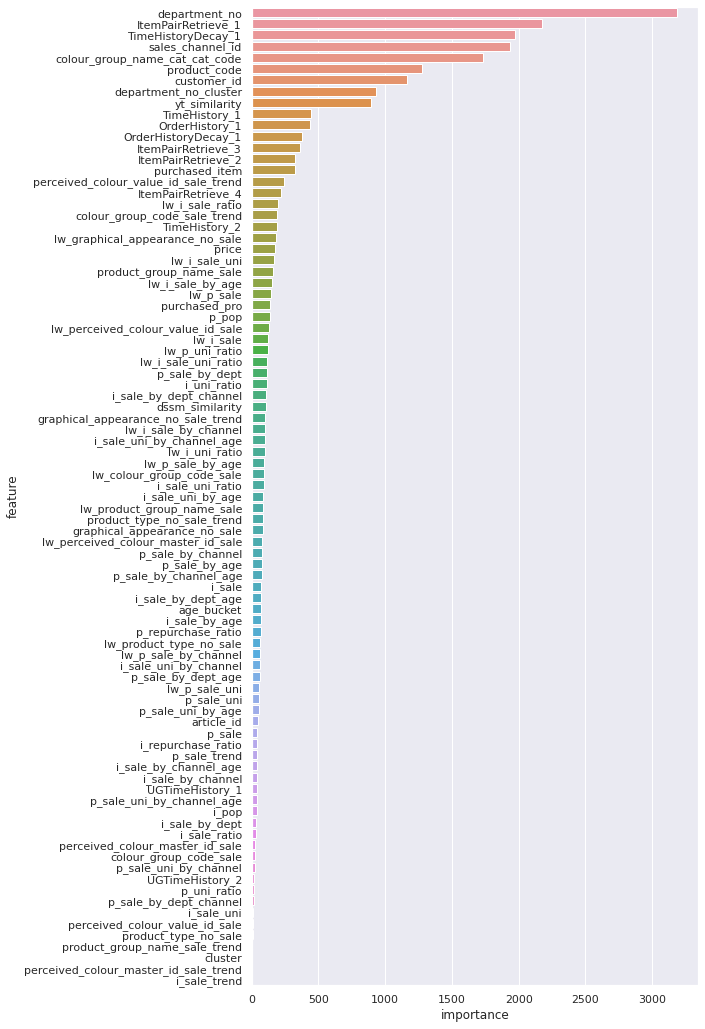

In [44]:
sns.set(rc={'figure.figsize':(8, 18)})
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
sns.barplot(y="feature", x="importance", data=feat_importance)

## Validate

In [45]:
val_candidates = candidates[1]

In [46]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [68]:
pred = predict(ranker_list[0], val_candidates)

label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

map_at_k(label["article_id"], label["prediction"], k=12)

# 0.028297597743100006 6 week 0.0250

# 0.02863472423766257 4 week
# 0.02882844782917304 4 week
# 0.028909064246733205 4 week
# 0.029366338019601947 4 week # 0.0268
# 0.029402247883421353 6 week

# 0.022458255193628294 3 week binary

100%|██████████| 1319568/1319568 [00:48<00:00, 27455.70it/s]


0.004870599090334677

In [69]:
print(recall_at_k(label["article_id"], label["prediction"], k=200))
print(recall_at_k(label["article_id"], label["prediction"], k=150))
print(recall_at_k(label["article_id"], label["prediction"], k=12))

0.14124239528292495
0.14123949605991673
0.02133036070868707


In [67]:
def predict_fold(ranker_list, candidates, feats, batch_size = 5_000_000):
    
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        fold_output = []
        for lgb_ranker in ranker_list:
            fold_output.append(lgb_ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats]))
        probs[batch : batch + batch_size] = sum(fold_output)/5 
        
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [51]:
ranker_list = []
for i in range(5):
    ranker_list.append(lgb.Booster(model_file = model_dir / f"lgb_binary_{i}_1.model"))

In [58]:
val_candidates.shape[0]

17198437

In [53]:
pred = predict_fold(ranker_list, val_candidates, trn_feats)

label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

map_at_k(label["article_id"], label["prediction"], k=12)

100%|██████████| 1319568/1319568 [00:52<00:00, 25100.71it/s]


0.005755164403391556

In [54]:
print(recall_at_k(label["article_id"], label["prediction"], k=200))
print(recall_at_k(label["article_id"], label["prediction"], k=150))
print(recall_at_k(label["article_id"], label["prediction"], k=12))

0.14124239528292495
0.1412399792637514
0.02236298792467445


In [ ]:
# pred = predict(ranker_2, val_candidates)

# label = labels[1]
# label = pd.merge(label, pred, on="customer_id", how="left")

# map_at_k(label["article_id"], label["prediction"], k=12)

# # 0.028297597743100006 6 week 0.0250

# # 0.02863472423766257 4 week
# # 0.02882844782917304 4 week
# # 0.028909064246733205 4 week
# # 0.029366338019601947 4 week # 0.0268
# # 0.029402247883421353 6 week

# # 0.022458255193628294 3 week binary

In [ ]:
# print(recall_at_k(label["article_id"], label["prediction"], k=200))
# print(recall_at_k(label["article_id"], label["prediction"], k=150))
# print(recall_at_k(label["article_id"], label["prediction"], k=12))

# # 0.22609381056959738
# # 0.20330711927052456
# # 0.05715520910553712

In [ ]:
pred = predict(ranker, val_candidates)

label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

map_at_k(label["article_id"], label["prediction"], k=12)

# 0.028297597743100006 6 week 0.0250

# 0.02863472423766257 4 week
# 0.02882844782917304 4 week
# 0.028909064246733205 4 week
# 0.029366338019601947 4 week # 0.0268

# 0.029402247883421353 6 week
# 0.02606931574775391 3 week ranker

In [ ]:
print(recall_at_k(label["article_id"], label["prediction"], k=200))
print(recall_at_k(label["article_id"], label["prediction"], k=150))
print(recall_at_k(label["article_id"], label["prediction"], k=12))

# 0.22610105862711796
# 0.19685366988994157
# 0.059677054468807014

In [ ]:
kkkkkkk

## Test

In [ ]:
del val_candidates, candidates
gc.collect()

In [ ]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
for feat in cat_features:
    test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

In [ ]:
test_pred = predict(ranker, test_candidates)

In [ ]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [ ]:
test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))

In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
del submission['prediction']
submission = submission.merge(test_pred, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [ ]:
submission.to_csv('submission.csv.gz', index=False)

In [ ]:
submission.head()

### Submit

In [ ]:
submit_msg = """
0.029402247883421353 6-week
---
OrderHistory(train, 3),
OrderHistory(train, 7),
OrderHistoryDecay(train, 3, n=50),
OrderHistoryDecay(train, 7, n=50),
ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),
TimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),
TimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),
TimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),
TimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),
SaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)
---
min_pos_rate = 0.005 new features
pivot
"""

In [ ]:
submit_msg

In [ ]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f "submission.csv.gz" -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'
